In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

In [2]:
import numpy as np

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters

register = AtomArrangement()
register.add([0, 0])

In [3]:
Omega_max = 2.5e6  # rad / seconds
trange = np.linspace(0, 4*np.pi/Omega_max, 21)[1:]

def get_program(t_max):
    Omega = TimeSeries()
    Omega.put(0.0, Omega_max)
    Omega.put(t_max, Omega_max)

    # e.g. all-zero phase and detuning
    phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
    Delta_global = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad/s])

    drive = DrivingField(
        amplitude=Omega,
        phase=phi,
        detuning=Delta_global
    )
    
    ahs_program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )
    
    return ahs_program
    
programs = [get_program(t) for t in trange]

In [4]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")


In [5]:
results = [device.run(ahs_program, shots=1000).result() for ahs_program in programs]


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004021238596594935 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004272566008882119 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004523893421169302 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-pac

In [6]:
from collections import Counter


def get_counts(result):
    """Aggregate state counts from AHS shot results
        A count of strings (of length = # of atoms) are returned, where
        each character denotes the state of an atom (site):
            e: empty site
            r: Rydberg state atom
            g: ground state atom
        Args:
            result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)
        Returns:
            dict: number of times each state configuration is measured
    """

    state_counts = Counter()
    states = ['e', 'r', 'g']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))

    return dict(state_counts)

In [7]:
counts = [get_counts(result) for result in results]

In [8]:
counts

[{'g': 909, 'r': 91},
 {'g': 669, 'r': 331},
 {'g': 344, 'r': 656},
 {'g': 95, 'r': 905},
 {'r': 1000},
 {'g': 86, 'r': 914},
 {'g': 325, 'r': 675},
 {'g': 642, 'r': 358},
 {'g': 880, 'r': 120},
 {'g': 1000},
 {'g': 888, 'r': 112},
 {'g': 675, 'r': 325},
 {'g': 361, 'r': 639},
 {'g': 106, 'r': 894},
 {'r': 1000},
 {'g': 97, 'r': 903},
 {'g': 375, 'r': 625},
 {'g': 670, 'r': 330},
 {'g': 931, 'r': 69},
 {'g': 1000}]

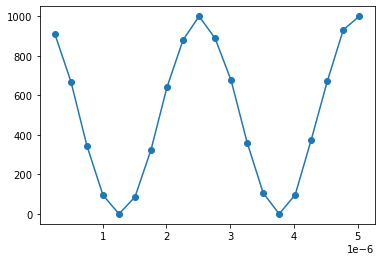

In [9]:
import matplotlib.pyplot as plt

plt.plot(trange, [count['g'] if 'g' in count else 0 for count in counts], 'o-')